<a href="https://colab.research.google.com/drive/1fb6wt9QKQrSKDwDK7HSXUEqfE9cQ1cUO?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)


# DDPG [Deep Deterministic Policy Gradient](https://arxiv.org/pdf/1509.02971.pdf)

**Deterministic Policy** means that the Actor gives the *best* believed action for any given state (no argmax). 

In DDPG, the ideas underlying the (DQN) are adapted to **continuous action** domains.



## Install

In [0]:
!pip install gym
!pip install box2d-py
# !pip install pyglet==1.3.2
!pip install pyglet

     |████████████████████████████████| 450kB 6.6MB/s 


In [0]:
!pip install stable-baselines[mpi]

## Agent and Env.

In [0]:
import gym
import numpy as np
from stable_baselines.ddpg.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.ddpg.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec
from stable_baselines import DDPG
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines import results_plotter
from stable_baselines.bench import Monitor
import time
import matplotlib.pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
env = gym.make('Pendulum-v0') 
env = DummyVecEnv([lambda: env])

# noise objects for DDPG
n_actions = env.action_space.shape[-1]
param_noise = None
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Train

In [0]:
total_timesteps = 100000 
best_mean_reward = -np.inf
n_steps = 0
score_list = []
avg_scores = []
episodes = 0
prev_episode_score = 0
prev_episode_step = 0
save_every = 10000

import os
# Create log dir
log_dir = "log/"
os.makedirs(log_dir, exist_ok=True)

In [0]:
def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    _locals['reward'], current reward
    _locals['episodes'],  episode number 
    _locals['episode_step'], steps in episode
    _locals['episode_reward']), accumilative reward 
    _locals['total_timesteps']
    _locals['episode_rewards_history'] last 100  
    """
    global n_steps, best_mean_reward, episodes, prev_episode_step, score_list, avg_scores, prev_episode_score
    
    if _locals['episodes'] > episodes: # new episode 
        episodes = _locals['episodes']
        total_timesteps = _locals['total_timesteps']
        score_list.append(prev_episode_score)
        avg_scores.append(np.mean(score_list[-10:]))
        print("\rStep({}/{} [{:.2f}%]) - Episode ({}) - Lengh({}) - Reward({:.2f}) - Reward mean({:.2f}) ".format(
            n_steps,
            total_timesteps,
            n_steps/total_timesteps*100.0,
            episodes,
            prev_episode_step,
            prev_episode_score,
            np.mean(_locals['episode_rewards_history']))
            , end="")
    prev_episode_score = _locals['episode_reward']
    prev_episode_step = _locals['episode_step']

    if (n_steps + 1) % save_every == 0:
      _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    return True

In [0]:
model = DDPG(MlpPolicy, env, verbose=0, param_noise=param_noise, action_noise=action_noise)
model.learn(total_timesteps=total_timesteps, callback=callback)
model.save("ddpg_mountain")





Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Step(99800/100000 [99.80%]) - Episode (499) - Lengh(200) - Reward(-245.89) - Reward mean(-797.80) 

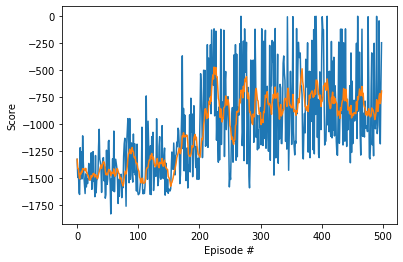

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(score_list)), score_list)
plt.plot(np.arange(len(avg_scores)), avg_scores)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [0]:
del model # to demonstrate saving and loading

## Test

In [0]:
env_test = gym.make('Pendulum-v0')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
model = DDPG.load("ddpg_mountain")

r = 0.0
obs = env_test.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env_test.step(action)
    r += rewards
    if dones:
      break
r

-2.3634853371757636